In [1]:
# import libraries
from pyspark.sql import SparkSession, Window
import pyspark.sql.functions as F
from pyspark.sql.types import FloatType
from pyspark.sql.types import IntegerType
#from pyspark import SparkFiles
#from pyspark.sql.functions import avg, col, concat, count, desc, \
#asc, explode, lit, min, max, split, stddev, udf, isnan, when, rank, \
#log, sqrt, cbrt, exp, sum

from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import LogisticRegression, \
LogisticRegressionModel, RandomForestClassifier, \
RandomForestClassificationModel, GBTClassifier, \
GBTClassificationModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, \
PCA, RegexTokenizer, Tokenizer, StandardScaler, StopWordsRemover, \
StringIndexer, VectorAssembler, MaxAbsScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.clustering import KMeans
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import time
import tqdm
import re
import numpy as np
import scipy
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
import random
%matplotlib inline
random.seed(42)

In [2]:
def create_spark_session():
    '''
    Create a spark session
    INPUT
    spark session builder
    OUTPUT
    spark object
    '''
    spark = SparkSession\
    .builder \
    .master("local") \
    .appName("sparkify") \
    .config("config option", "config value")\
    .getOrCreate()
    print('Spark parameters:')
    for parameter in spark.sparkContext.getConf().getAll():
        print(parameter)

    return spark

In [3]:
def load_models():
    lr = PipelineModel.load("logistic")
    rf = PipelineModel.load("random_forest")
    gbt = PipelineModel.load("gradient_boosted_tree")
    grid = PipelineModel.load("grid")

    return lr, rf, gbt, grid

In [4]:
def load_predictions():
    rf_yhat = spark.read.load("rf_preds.parquet")
    lr_yhat = spark.read.load("lr_preds.parquet")
    gbt_yhat = spark.read.load("gbt_preds.parquet")
    grid_yhat = spark.read.load("rf_grid_preds.parquet")
    
    return rf_yhat, lr_yhat, gbt_yhat, grid_yhat

In [5]:
def load_metrics():
    rf_metrics = pd.read_csv('rf_metrics.csv')
    lr_metrics = pd.read_csv('lr_metrics.csv')
    gbt_metrics = pd.read_csv('gbt_metrics.csv')
    grid_metrics = pd.read_csv('rf_grid_metrics.csv')
    
    return rf_metrics, lr_metrics, gbt_metrics, grid_metrics 

In [6]:
def calc_logloss(df):

    # extract predicted probability
    get_first_element = F.udf(lambda v:float(v[1]), FloatType())
    df = df.withColumn("preds", get_first_element(F.col("probability")))

    # calculate negative log-likelihood
    y1, y0 = F.col("label"), 1 - F.col("label")
    p1, p0 = F.col("preds"), 1 - F.col("preds")
    nll = -(y1*F.log(p1) + y0*F.log(p0))

    # aggregate
    return df.agg(F.mean(nll)).collect()[0][0]

def save_logloss_vals(rf_yhat_test, lr_yhat_test, gbt_yhat_test, grid_yhat_test):
    logloss = {}
    logloss['rf'] = calc_logloss(rf_yhat_test)
    logloss['lr'] = calc_logloss(lr_yhat_test)
    logloss['gbt'] = calc_logloss(gbt_yhat_test)
    logloss['grid'] = calc_logloss(grid_yhat_test)
    #logloss_df = pd.DataFrame.from_dict(logloss, orient = 'index', columns = ['logloss'])
    #logloss_df.to_csv('logloss.csv', index = True)
    
    return logloss

In [40]:
def extract_probs(df):

    # extract predicted probability
    get_prob_zero = F.udf(lambda v:float(v[0]), FloatType())
    get_prob_one = F.udf(lambda v:float(v[1]), FloatType())
    df = df.withColumn("prob_zero", get_prob_zero(F.col("probability")))
    df = df.withColumn("prob_one", get_prob_one(F.col("probability")))
    #df = df.withColumn("log_zero", F.log(F.col("prob_zero")))
    #df = df.withColumn("log_one", F.log(F.col("prob_one")))
    

    #df = df.withColumn("logloss", -(F.col("label")*F.log(F.col("prob_one"))+ (1 - F.col("label"))*F.log(1-F.col("prob_one"))))
    
    #nll = -(y1*F.log(p1) + y0*F.log(p0))
    # aggregate
    return df.select("label", "probability", "prediction", "prob_zero", "prob_one")

    
    
def gen_logloss_metric(rf_yhat_test, lr_yhat_test, gbt_yhat_test):
    logloss = {}
    logloss['rf'] = log_loss(rf_yhat_test)
    logloss['lr'] = log_loss(lr_yhat_test)
    logloss['gbt'] = log_loss(gbt_yhat_test)
    logloss_df = pd.DataFrame.from_dict(logloss, orient = 'index', columns = ['logloss'])
    logloss_df.to_csv('logloss.csv', index = True)
    
    return logloss

def calc_logloss_pd(df):

    df['logloss'] = -(df.label*np.log10(df.prob_one) + (1 - df.label)*np.log10(df.prob_zero))
    
    return df

def get_plot_cols(df):
    idx = df.prob_zero.sort_values().index
    x = df.prob_zero.sort_values().values
    df['logloss'].index = idx
    y = df.logloss.cumsum()
    
    return x, y

In [8]:
spark = create_spark_session()

Spark parameters:
('spark.master', 'local')
('spark.app.name', 'sparkify')
('spark.driver.port', '39827')
('spark.rdd.compress', 'True')
('spark.serializer.objectStreamReset', '100')
('config option', 'config value')
('spark.executor.id', 'driver')
('spark.submit.deployMode', 'client')
('spark.app.id', 'local-1633365873016')
('spark.ui.showConsoleProgress', 'true')
('spark.driver.host', '633ae16c1532')


#### Load models and predictions

In [9]:
rf_yhat, lr_yhat, gbt_yhat, grid_yhat = load_predictions()
lr, rf, gbt, grid = load_models()
rf_metrics, lr_metrics, gbt_metrics, grid_metrics = load_metrics()

In [10]:
logloss_dict = save_logloss_vals(rf_yhat, lr_yhat, gbt_yhat, grid_yhat)

In [11]:
logloss_dict

{'rf': 0.424599314328071,
 'lr': 10.990544194361663,
 'gbt': 0.3260454592217635,
 'grid': 0.2552869958645805}

In [21]:
lr_params = {param[0].name: [param[1], param[0].doc] for param in lr.stages[2].extractParamMap().items()}
lr_params_pd = pd.DataFrame.from_dict(lr_params, orient = 'index', columns = ['Parameter', 'Explanation'])
lr_params_pd.to_csv('lr_params.csv')

In [22]:
rf_params = {param[0].name: [param[1], param[0].doc] for param in rf.stages[2].extractParamMap().items()}
rf_params_pd = pd.DataFrame.from_dict(rf_params, orient = 'index', columns = ['Parameter', 'Explanation'])
rf_params_pd.to_csv('rf_params.csv')

In [23]:
gbt_params = {param[0].name: [param[1], param[0].doc] for param in gbt.stages[2].extractParamMap().items()}
gbt_params_pd = pd.DataFrame.from_dict(gbt_params, orient = 'index', columns = ['Parameter', 'Explanation'])
gbt_params_pd.to_csv('gbt_params.csv')

In [24]:
grid_params = {param[0].name: [param[1], param[0].doc] for param in grid.stages[2].extractParamMap().items()}
grid_params_pd = pd.DataFrame.from_dict(grid_params, orient = 'index', columns = ['Parameter', 'Explanation'])
grid_params_pd.to_csv('grid_params.csv')

In [25]:
lr_params_pd

,Parameter,Explanation
aggregationDepth,2,suggested depth for treeAggregate (>= 2)
elasticNetParam,0,"the ElasticNet mixing parameter, in range [0, ..."
family,auto,The name of family which is a description of t...
fitIntercept,True,whether to fit an intercept term
maxIter,100,maximum number of iterations (>= 0)
predictionCol,prediction,prediction column name
probabilityCol,probability,Column name for predicted class conditional pr...
rawPredictionCol,rawPrediction,raw prediction (a.k.a. confidence) column name
regParam,0,regularization parameter (>= 0)
standardization,True,whether to standardize the training features b...


In [26]:
rf_params_pd

,Parameter,Explanation
cacheNodeIds,False,"If false, the algorithm will pass trees to exe..."
checkpointInterval,10,set checkpoint interval (>= 1) or disable chec...
featureSubsetStrategy,auto,The number of features to consider for splits ...
impurity,gini,Criterion used for information gain calculatio...
maxBins,32,Max number of bins for discretizing continuous...
maxDepth,5,"Maximum depth of the tree. (>= 0) E.g., depth ..."
maxMemoryInMB,256,Maximum memory in MB allocated to histogram ag...
minInfoGain,0,Minimum information gain for a split to be con...
minInstancesPerNode,1,Minimum number of instances each child must ha...
numTrees,20,Number of trees to train (>= 1)


In [27]:
gbt_params_pd

,Parameter,Explanation
cacheNodeIds,False,"If false, the algorithm will pass trees to exe..."
checkpointInterval,10,set checkpoint interval (>= 1) or disable chec...
featureSubsetStrategy,all,The number of features to consider for splits ...
impurity,gini,Criterion used for information gain calculatio...
lossType,logistic,Loss function which GBT tries to minimize (cas...
maxBins,32,Max number of bins for discretizing continuous...
maxDepth,5,"Maximum depth of the tree. (>= 0) E.g., depth ..."
maxIter,20,maximum number of iterations (>= 0)
maxMemoryInMB,256,Maximum memory in MB allocated to histogram ag...
minInfoGain,0,Minimum information gain for a split to be con...


In [28]:
grid_params_pd

,Parameter,Explanation
cacheNodeIds,False,"If false, the algorithm will pass trees to exe..."
checkpointInterval,10,set checkpoint interval (>= 1) or disable chec...
featureSubsetStrategy,auto,The number of features to consider for splits ...
impurity,gini,Criterion used for information gain calculatio...
maxBins,32,Max number of bins for discretizing continuous...
maxDepth,5,"Maximum depth of the tree. (>= 0) E.g., depth ..."
maxMemoryInMB,256,Maximum memory in MB allocated to histogram ag...
minInfoGain,0,Minimum information gain for a split to be con...
minInstancesPerNode,1,Minimum number of instances each child must ha...
predictionCol,prediction,prediction column name


In [37]:
rf_probs = extract_probs(rf_yhat)
lr_probs = extract_probs(lr_yhat)
gbt_probs = extract_probs(gbt_yhat)
grid_probs = extract_probs(grid_yhat)

In [34]:
rf_grid_loss.show(5)

+-----+--------------------+----------+----------+----------+
|label|         probability|prediction| prob_zero|  prob_one|
+-----+--------------------+----------+----------+----------+
|    0|[0.87586502083176...|       0.0|0.87586504|0.12413498|
|    1|[0.24307379174770...|       1.0|0.24307379| 0.7569262|
|    1|[0.19561880711880...|       1.0|0.19561881| 0.8043812|
|    0|[0.60384232249232...|       0.0| 0.6038423|0.39615768|
|    1|[0.17763615748600...|       1.0|0.17763616|0.82236385|
+-----+--------------------+----------+----------+----------+
only showing top 5 rows



https://stackoverflow.com/questions/50061577/how-to-create-a-new-column-based-on-calculations-made-in-other-columns-in-pyspar

In [38]:
rf_pd = rf_probs.toPandas()
lr_pd = lr_probs.toPandas()
gbt_pd = gbt_probs.toPandas()
grid_pd = grid_probs.toPandas()

In [41]:
rf_pd = calc_logloss_pd(rf_pd)
lr_pd = calc_logloss_pd(lr_pd)
gbt_pd = calc_logloss_pd(gbt_pd)
grid_pd = calc_logloss_pd(grid_pd)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10


In [42]:
lr_pd['logloss'].replace(np.inf, np.nan, inplace = True)
lr_pd.logloss.fillna(0, inplace = True)

In [43]:
rf_pd['logloss'].sum()

9.2200572658330202

In [44]:
lr_pd['logloss'].sum()

74.98453191936207

In [45]:
gbt_pd['logloss'].sum()

11.752778589725494

In [47]:
grid_pd['logloss'].sum()

9.202188335621031

In [50]:
rf_x, rf_y = get_plot_cols(rf_pd)
lr_x, lr_y = get_plot_cols(lr_pd) 
gbt_x, gbt_y = get_plot_cols(gbt_pd)
grid_x, grid_y = get_plot_cols(grid_pd)

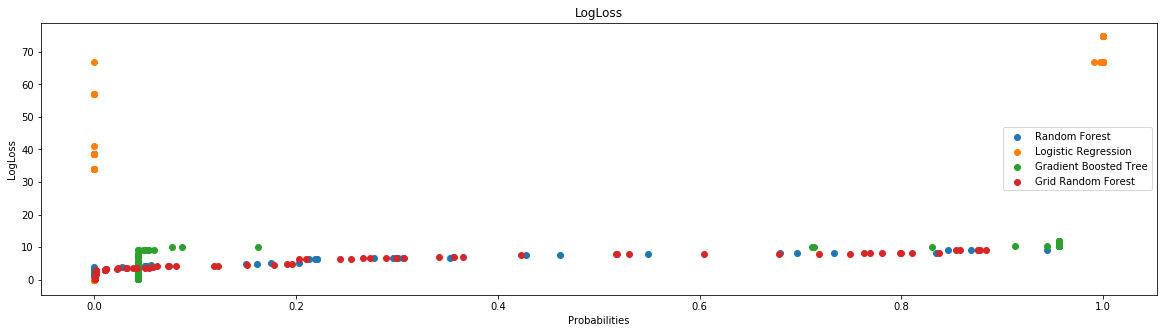

In [52]:
plt.figure(figsize = [20,5])
plt.scatter(rf_x, rf_y, label = "Random Forest")
plt.scatter(lr_x, lr_y, label ="Logistic Regression")
plt.scatter(gbt_x, gbt_y, label = "Gradient Boosted Tree")
plt.scatter(grid_x, grid_y, label = "Grid Random Forest")
plt.legend()
plt.title('LogLoss')
plt.ylabel('LogLoss')
plt.xlabel('Probabilities');

(5.5, 10)

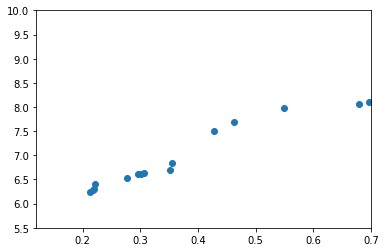

In [53]:
plt.scatter(rf_x, rf_y)
plt.xlim(0.12, 0.7)
plt.ylim(5.5,10)